In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [2]:
#入力データのロード
x = np.load('x.npy')
x_range0=[min(x[:,0]),max(x[:,0])]
x_range1=[min(x[:,1]),max(x[:,1])]

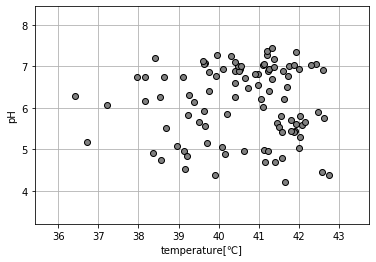

In [3]:
#入力データの図示
plt.plot(x[:,0],x[:,1],linestyle='none',markeredgecolor='black',marker='o',color='gray')
plt.xlim([min(x[:,0])-1,max(x[:,0])+1])
plt.ylim([min(x[:,1])-1,max(x[:,1])+1])
plt.xlabel('temperature[℃]')
plt.ylabel('pH')
plt.grid(True)
plt.show()

In [4]:
#２次元ガウス関数 x:N*D行列、mu:1*D行列（中心ベクトル） sigma:D*D行列(共分散行列)
def gauss_2d(x,mu,sigma):
    N,D = x.shape
    i1 = 1 / (((2 * np.pi)**(D/2))*(np.linalg.det(sigma)**(1/2)))
    inv_sigma = np.linalg.inv(sigma)
    i2 = x - mu                        #i2:N*D行列
    i3 = np.dot(i2,inv_sigma)          #i3:N*D行列
    i4 = np.zeros(N)
    for d in range(D):
        i4 += i3[:,d]*i2[:,d]
    p = i1 * np.exp(-i4 / 2)
    return p

In [5]:
#混合ガウスモデル x:N*D行列、mu:K*D行列（K個の中心ベクトル） sigma:K*(D*D)行列(K個の共分散行列)
def gauss_mixture(x,pi,mu,sigma):
    N,D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p += pi[k]*gauss_2d(x,mu[k,:],sigma[k,:,:])
    return p

In [6]:
# 混合ガウスモデルの等高線表示
def show_contour_gauss_mixture(x,pi,mu,sigma):
    xn=40 #解像度
    x0=np.linspace(x_range0[0]-1,x_range0[1]+1,xn)
    x1=np.linspace(x_range1[0]-1,x_range1[1]+1,xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x=np.c_[np.reshape(xx0,xn*xn,1),np.reshape(xx1,xn*xn,1)]
    f=gauss_mixture(x,pi,mu,sigma)
    f=f.reshape(xn,xn)
    f=f.T
    plt.contour(x0,x1,f,10,colors='gray')
    

In [7]:
# 混合ガウスモデル3D表示
def show3d_gauss_mixture(x,ax,pi,mu,sigma):
    xn=40
    x0=np.linspace(x_range0[0]-1,x_range0[1]+1,xn)
    x1=np.linspace(x_range1[0]-1,x_range1[1]+1,xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x=np.c_[np.reshape(xx0,xn*xn,1),np.reshape(xx1,xn*xn,1)]
    f=gauss_mixture(x,pi,mu,sigma)
    f=f.reshape(xn,xn)
    f=f.T
    ax.plot_surface(xx0,xx1,f,rstride=2,cstride=2,alpha=0.3,color='blue',edgecolor='black')

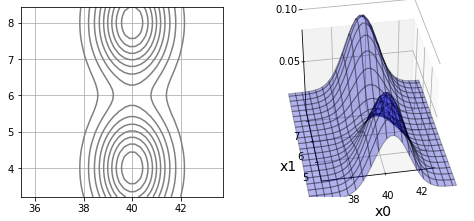

In [8]:
#等高線・3D表示のテスト
pi = np.array([0.5, 0.5])
mu = np.array([[40,4],[40,8]])
sigma = np.array([[[1,0],[0,1]],[[1,0],[0,1]]])

fig=plt.figure(1,figsize=(8,3.5))
fig.add_subplot(1,2,1)
show_contour_gauss_mixture(x,pi,mu,sigma)
plt.grid(True)

Ax=fig.add_subplot(1,2,2,projection='3d')
show3d_gauss_mixture(x,Ax,pi,mu,sigma)
Ax.set_zticks([0.05,0.10])
Ax.set_xlabel('x0',fontsize=14)
Ax.set_ylabel('x1',fontsize=14)
Ax.view_init(40,-100)
plt.xlim(x_range0)
plt.ylim(x_range1)
plt.show()



In [9]:
#EMアルゴリズム

#パラメータの初期設定
N = x.shape[0]
K = 3
Pi = np.array([0.33,0.33,0.34])
Mu = np.array([[36,5],[36,6],[36,7]])
Sigma = np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
Gamma = np.c_[np.ones((N,1)),np.zeros((N,2))]

X_col = np.array([[0.4,0.6,0.95],[1,1,1],[0,0,0]])

In [10]:
#データの図示
def show_gauss_mixture_prm(x,gamma,pi,mu,sigma):
    N,D=x.shape
    show_contour_gauss_mixture(x,pi,mu,sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n,0],x[n,1],'o',color=tuple(col),markeredgecolor='black',markersize=6,alpha=0.5)
    
    for k in range(K):
        plt.plot(mu[k,0],mu[k,1],marker='*',markerfacecolor=tuple(X_col[k]),markersize=15,markeredgecolor='k',markeredgewidth=1)

    plt.grid(True)
            

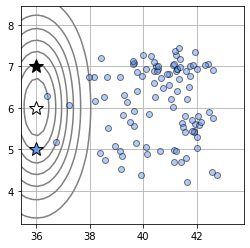

In [11]:
#図示テスト
plt.figure(1,figsize=(4,4))
show_gauss_mixture_prm(x,Gamma,Pi,Mu,Sigma)
plt.show()

In [12]:
#EMアルゴリズムのE step:gammaを更新する
def e_step_gauss_mixture(x,pi,mu,sigma):
    N,D=x.shape
    K=len(pi)
    y=np.zeros((N,K))
    for k in range(K):
        y[:,k]=gauss_2d(x,mu[k,:],sigma[k,:,:]) #K*N
    gamma=np.zeros((N,K))
    for n in range(N):
        wk=np.zeros(K)
        for k in range(K):
            wk[k]=pi[k]*y[n,k]
        gamma[n,:]=wk/np.sum(wk)
    return gamma

In [13]:
#Gamma更新
Gamma = e_step_gauss_mixture(x,Pi,Mu,Sigma)

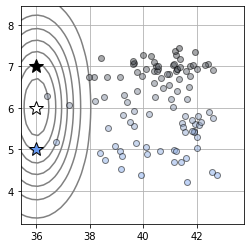

In [14]:
#表示
plt.figure(1,figsize=(4,4))
show_gauss_mixture_prm(x,Gamma,Pi,Mu,Sigma)
plt.show()

In [15]:
#EMアルゴリズムのM step:Pi,Mu,Sigmaを更新する
def m_step_gauss_mixture(x,gamma):
    N,D=x.shape
    N,K=gamma.shape
    #piを計算
    pi=np.sum(gamma,axis=0)/N
    #muを計算
    mu=np.zeros((K,D))
    for k in range(K):
        for d in range(D):
            mu[k,d]=np.dot(gamma[:,k],x[:,d]) / np.sum(gamma[:,k])
    #sigmaを計算
    sigma=np.zeros((K,D,D))
    for k in range(K):
        for n in range(N):
            wk = x-mu[k,:]
            wk = wk[n,:,np.newaxis]
            sigma[k,:,:]=sigma[k,:,:]+gamma[n,k]*np.dot(wk,wk.T)
        sigma[k,:,:]=sigma[k,:,:]/np.sum(gamma[:,k])
    return pi,mu,sigma


In [16]:
#Pi,Mu,Sigma更新
Pi,Mu,Sigma=m_step_gauss_mixture(x,Gamma)

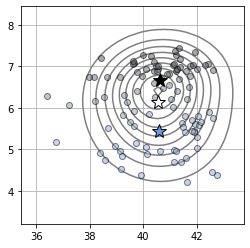

In [17]:
#表示
plt.figure(1,figsize=(4,4))
show_gauss_mixture_prm(x,Gamma,Pi,Mu,Sigma)
plt.show()

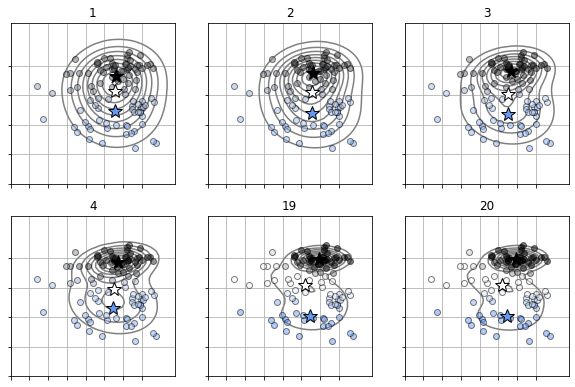

In [18]:
#E stepとM stepを繰り返す
plt.figure(1,figsize=(10,6.5))
max_it=20 #繰り返しの回数

i_subplot=1
for it in range(0,max_it):
    Gamma = e_step_gauss_mixture(x,Pi,Mu,Sigma)
    if it<4 or it>17:
        plt.subplot(2,3,i_subplot)
        show_gauss_mixture_prm(x,Gamma,Pi,Mu,Sigma)
        plt.title("{0:d}".format(it+1))
        plt.xticks(range(int(x_range0[0])-1,int(x_range0[1])+1),"")
        plt.yticks(range(int(x_range1[0])-1,int(x_range1[1])+1),"")
        i_subplot=i_subplot+1
    Pi,Mu,Sigma=m_step_gauss_mixture(x,Gamma)
plt.show()
        